<a href="https://colab.research.google.com/github/VKSi/2021_02_GB_PyTorch/blob/main/HW_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> “Фреймворк PyTorch для разработки искусственных нейронных сетей”</center></h1>

<center><h1>Long Shot-Term Memory</h1> </center>

**Домашнее задание: **       
1) Приложен ноутбук, в котором реализованы функции для генирации из большого датасета меньшая его копия. Вам нужно перенести функции из этого ноутбука в класс датасет и сделать следующее: 
Сгенерировать меньший датасет из 8-10 классов движения
Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить)
Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели  
Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса.
     
2) Дополнительное задание:
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно. Предсказывать нужно Global_active_power. Обратите внимание, что здесь задача регрессии, а не классификации, т.е. модель нужно изменить.


## Подготовка окружения

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/PyTorch/'
DATA_PATH = PATH + 'data/skeletons/'
PATH_L2 = PATH + 'Lesson2/'
broken_files_path = DATA_PATH + 'NTU_RGBD_samples_with_missing_skeletons.txt'
DATA_ZIP = DATA_PATH + 'nturgbd_skeletons_s001_to_s017.zip'

In [ ]:
!pip3 install torch torchvision

In [ ]:
import os
from zipfile import ZipFile

import pandas as pd
import numpy as np
import torch

%matplotlib inline
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms
from torch import nn

from torch.utils.data import DataLoader, Dataset

### Функции из предоставленного ноутбука   
### Я изменил их так, чтобы отбор и загрузка шли непосредственно из ZIP файла без необходимости распаковки множества ненужных данных

Будем передавать параметры для фильтрации в виде словаря

In [ ]:
filter_params = dict(
    training_subjects = list(range(0, 28)), #количество людей выполняющих действия
    training_classes = [8*i for i in range(1, 11)] + [10, 22, 23],  #классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
    training_cameras = [1, 2, 3], 
    max_body_true = 1,
    max_body_kinect = 1,
    num_joint = 25,
    max_frame = 300, # Длина отрезка которую мы вычленяем из большого датасета
    chonk_len = 45
    )

In [ ]:
def read_data(data_path, broken_files_path, filter_params):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    num_frames = 0

    with ZipFile(data_path) as z:
      for filename in z.namelist():
          if (not os.path.isdir(filename)) & (filename[19:] not in broken_files):
              action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
              subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
              camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
              if action_class in filter_params['training_classes'] and camera_id in filter_params['training_cameras']:  #and subject_id in training_subjects:
                  if action_class in action_classes:
                      if files_counter[action_class] < 120:
                          files.append([filename,action_classes[action_class]])
                          files_counter[action_class] = files_counter[action_class] + 1
                  else:
                      action_classes.update({action_class : counter})
                      files_counter.update({action_class : 1})
                      counter+=1
                      files.append([filename,action_classes[action_class]])
  #                     labels.append([action_class])
      print("action classes: ", action_classes)
      print("action files: ", files_counter)
    
    return files, action_classes

In [ ]:
def get_nonzero_std(s): 
    index = s.sum(-1).sum(-1) != 0  
    s = s[index]
    if len(s) != 0:
        s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
    else:
        s = 0
    return s

# Функция фильтр для того, что бы найти только координаты x,y,z(т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
def read_skeleton_filter(file, zip_f):
    with zip_f.open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []
        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, zip_f, filter_params):
    seq_info = read_skeleton_filter(file, zip_f)
    data = np.zeros((filter_params['max_body_true'], seq_info['numFrame'], filter_params['num_joint'], 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < filter_params['max_body_true'] and j < filter_params['num_joint']:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

                else:
                    pass

    return data

In [ ]:
def create_coords_blocks(test_file, zip_f, filter_params):   
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(test_file[0], zip_f, filter_params)[0]
    label = test_file[1]
    slice_len = filter_params['chonk_len'] * int(len(test_frames)/filter_params['chonk_len'])


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == filter_params['chonk_len']:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
    return blocks, new_labels

In [ ]:
##### список файлов с лейблами на каждый файл 
working_files_with_labels, action_classes = read_data(DATA_ZIP, broken_files_path, filter_params)

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}


In [ ]:
LABELS = {v: k for k, v in action_classes.items()}

In [ ]:
print(LABELS)

{0: 32, 1: 56, 2: 8, 3: 22, 4: 16, 5: 24, 6: 48, 7: 40, 8: 10, 9: 23}


In [ ]:
len(working_files_with_labels)

1200

In [ ]:
working_files_with_labels[:5]

[['nturgb+d_skeletons/S001C002P002R001A032.skeleton', 0],
 ['nturgb+d_skeletons/S007C001P007R001A056.skeleton', 1],
 ['nturgb+d_skeletons/S011C001P002R001A008.skeleton', 2],
 ['nturgb+d_skeletons/S006C002P024R001A022.skeleton', 3],
 ['nturgb+d_skeletons/S011C001P018R002A016.skeleton', 4]]

In [ ]:
def get_data(DATA_ZIP,broken_files_path, filter_params):
  working_files_with_labels, action_classes = read_data(DATA_ZIP, broken_files_path, filter_params)
  LABELS = {v: k for k, v in action_classes.items()}
  data = []
  labels = []
  numbers = {k: 0 for k in LABELS.keys()}

  with ZipFile(DATA_ZIP) as zip_f:
    for filename in working_files_with_labels:
      frames_blocks, label = create_coords_blocks(filename, zip_f, filter_params)
      if label != [] and numbers[label[0]] <= 150:
          numbers[label[0]] = numbers[label[0]] + len(label)
          data = data + frames_blocks
          labels = labels + label

  data_np = np.asarray(data)
  labels_np = np.asarray(labels)

  data_sq = data_np.reshape(len(data_np), -1)
  ready_data = pd.DataFrame(data_sq)
  ready_labels = pd.DataFrame(labels_np)
  ready_data['labels'] = ready_labels

  return ready_data, LABELS

In [ ]:
t = get_data(DATA_ZIP, broken_files_path, filter_params=filter_params)

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}


In [ ]:
t[0].shape

(1334, 3376)

In [ ]:
t[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.193471,-0.140196,3.485242,-0.159754,0.133422,3.439670,-0.127363,0.402663,3.383824,-0.145597,0.510845,3.376294,-0.227072,0.360714,3.534927,-0.255993,0.134265,3.495645,-0.134752,0.256110,3.414588,-0.132061,0.358414,3.336776,-0.094550,0.263088,3.281452,-0.138210,0.056787,3.241343,-0.321902,0.099285,3.199194,-0.391107,0.134990,3.183039,-0.223024,-0.130348,3.507784,-0.280733,...,-0.185792,-0.160926,3.409353,-0.280970,-0.323773,3.570357,-0.103755,-0.688489,3.646653,-0.120010,-0.744354,3.720368,-0.126721,-0.163590,3.399825,-0.117809,-0.413156,3.453264,-0.027964,-0.728872,3.596136,-0.117640,-0.773319,3.535858,-0.128405,0.364435,3.434550,-0.349257,0.322087,3.133922,-0.376204,0.322929,3.143286,-0.588851,0.421328,2.949086,-0.573784,0.373638,2.953000,0
1,0.407236,-0.203978,3.600792,0.433974,0.124048,3.656890,0.457121,0.445696,3.699517,0.431437,0.579589,3.753165,0.306630,0.243793,3.812185,0.273483,0.027468,3.682434,0.218870,-0.190255,3.574646,0.195540,-0.223983,3.534432,0.551095,0.312047,3.564009,0.615434,0.115159,3.468599,0.443447,0.070025,3.415957,0.397105,0.061316,3.450704,0.360194,-0.213031,3.605939,0.334220,...,0.216391,-0.256335,3.663712,0.250384,-0.615474,3.648983,0.287771,-0.934863,3.593733,0.219706,-0.959679,3.500273,0.304368,-0.230831,3.586034,0.382844,-0.578345,3.477036,0.487039,-0.932165,3.480299,0.479254,-1.003237,3.404302,0.232311,0.358571,3.724991,-0.326530,0.168164,3.487682,-0.290500,0.087987,3.432125,-0.237585,0.205093,3.328083,-0.211386,0.230131,3.320857,1
2,0.446281,-0.505178,3.613605,0.511625,-0.339683,3.544557,0.576402,-0.173786,3.470922,0.576861,-0.074490,3.522914,0.437913,-0.189105,3.586424,0.384508,-0.305087,3.617366,0.322038,-0.413022,3.560185,0.304304,-0.459686,3.560451,0.615941,-0.256144,3.459692,0.662969,-0.185256,3.350198,0.644102,-0.280778,3.361310,0.645627,-0.306123,3.378739,0.404268,-0.484900,3.611413,0.236868,...,0.370709,-0.459172,3.447222,0.090338,-0.493429,3.382947,0.097104,-0.847698,3.510185,0.132334,-0.871996,3.419879,0.461612,-0.491932,3.372618,0.221888,-0.523323,3.230454,0.192099,-0.842784,3.369629,0.142473,-0.876745,3.298210,0.502331,-0.039994,3.341697,0.077242,-0.368300,3.471564,0.120845,-0.304216,3.438000,0.338436,-0.436624,3.103175,0.378958,-0.375938,3.096923,2
3,0.024791,-0.395073,3.435248,0.023275,-0.136877,3.454380,0.023860,0.118253,3.461275,0.029232,0.231564,3.510573,-0.055970,-0.045257,3.511257,-0.112658,-0.179155,3.661581,-0.101223,-0.392077,3.597772,-0.102565,-0.448328,3.588785,0.073573,0.032559,3.361398,0.115630,-0.172983,3.292669,0.045506,-0.368436,3.252027,0.033632,-0.439177,3.265056,-0.009245,-0.397228,3.431382,0.027539,...,-0.035090,-0.358974,3.404099,0.015318,-0.730544,3.455158,0.102636,-1.050567,3.428672,0.086024,-1.108109,3.387944,0.043531,-0.352321,3.387692,0.071926,-0.701246,3.346902,0.133686,-1.041072,3.376576,0.100167,-1.098106,3.372944,0.015078,0.028433,3.372547,-0.094870,0.218149,3.710907,-0.096914,0.201950,3.711600,0.030358,0.453871,3.238714,0.022799,0.453902,3.228391,3
4,0.210425,-0.235758,3.166870,0.184179,0.031452,3.073890,0.161181,0.293710,2.969338,0.202360,0.394784,2.966507,0.062716,0.174857,2.932406,0.022847,-0.043181,2.962481,0.053478,-0.245025,2.983289,0.073164,-0.315761,3.006615,0.280872,0.222570,3.101913,0.314963,-0.007228,3.243066,0.327934,-0.228310,3.211354,0.327475,-0.281674,3.214828,0.158141,-0.240579,3.098086,0.089640,...,-0.098710,-0.338214,3.203073,0.179561,-0.611127,3.159227,0.145008,-0.863982,3.305909,0.160223,-0.770447,3.221680,-0.075856,-0.450601,3.255080,0.122238,-0.592438,3.059861,0.186497,-0.772249,3.279590,0.134901,-0.699701,3.157621,0.267699,-0.448802,2.980761,0.241956,-0.778819,3.118881,0.219262,-0.764364,3.117000,0.306501,-0.983596

### Переопределение класса Dataset для фильтрации данных из ZIP

In [ ]:
class Skeleton_Dataset(Dataset):
    def __init__(self, zip_file_path, broken_files_path, filter_params, transform=None):
        self.data, self.LABELS = get_data(zip_file_path, broken_files_path, filter_params)
        self.transform = transform
        self.filter_params = filter_params
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.filter_params['chonk_len'], 25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = self.transform(item)
        return (item, label) 

### Создание и тренировка модели из урока на 10 классах

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
dataset = Skeleton_Dataset(zip_file_path = DATA_ZIP, broken_files_path=broken_files_path, filter_params=filter_params) # , transform=transforms.ToTensor()

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}


In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [ ]:
n_hidden = 128
n_joints = 25*3
LABELS = dataset.LABELS
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
from torch import optim
import time
import math

def train_and_eval():
  criterion = nn.CrossEntropyLoss()
  learning_rate = 0.0007
  optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

  all_losses = []
  start = time.time()
  counter = 0
  for epoch in range(600):  
      current_loss = 0
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          
          inputs, labels = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
      
          output = rnn(inputs.float())
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step() 


          current_loss += loss.item()
          category = LABELS[int(labels[0])]

          if counter % 500 == 0:
              guess, guess_i = categoryFromOutput(output)
              correct = '✓' if guess == category else '✗ (%s)' % category
              print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

          
          counter = counter + 1
      if counter % 100 == 0:
          all_losses.append(current_loss / 25)
          current_loss = 0

  #----------------------------------------------------------------------------

  total = 0
  right = 0
  counter = 0

  rnn.eval()
  with torch.no_grad():
      for i, data in enumerate(test_loader, 0):
          counter = counter + 1
          inputs, labels = data[0].to(device), data[1].to(device)  
          output = rnn(inputs.float())
          guess, guess_i = categoryFromOutput(output)
          category = LABELS[int(labels[0])]
          
          if guess == category:
              right = right + 1


  print('Accuracy of the network:  ',  (100 * right / counter))

  #----------------------------------------------------------------------------

  plt.plot(all_losses)
  plt.show()

epoch : 0 iter : 0 (0m 0s) 1.9091  / 56 ✗ (48)
epoch : 7 iter : 59 (0m 13s) 0.9828  / 22 ✓
epoch : 15 iter : 55 (0m 26s) 1.1937  / 56 ✓
epoch : 23 iter : 51 (0m 39s) 1.1317  / 16 ✓
epoch : 31 iter : 47 (0m 52s) 1.0579  / 48 ✗ (10)
epoch : 39 iter : 43 (1m 5s) 0.9862  / 56 ✗ (24)
epoch : 47 iter : 39 (1m 19s) 0.8435  / 40 ✓
epoch : 55 iter : 35 (1m 32s) 0.6048  / 23 ✓
epoch : 63 iter : 31 (1m 45s) 1.0988  / 10 ✗ (48)
epoch : 71 iter : 27 (1m 58s) 0.7581  / 24 ✗ (56)
epoch : 79 iter : 23 (2m 11s) 0.9369  / 8 ✓
epoch : 87 iter : 19 (2m 25s) 0.9672  / 10 ✗ (56)
epoch : 95 iter : 15 (2m 38s) 1.1573  / 24 ✓
epoch : 103 iter : 11 (2m 51s) 1.0718  / 16 ✗ (32)
epoch : 111 iter : 7 (3m 4s) 1.0569  / 10 ✗ (24)
epoch : 119 iter : 3 (3m 17s) 0.6572  / 24 ✓
epoch : 126 iter : 62 (3m 31s) 1.2632  / 40 ✓
epoch : 134 iter : 58 (3m 44s) 0.5845  / 56 ✓
epoch : 142 iter : 54 (3m 57s) 0.6512  / 16 ✓
epoch : 150 iter : 50 (4m 10s) 0.5916  / 40 ✓
epoch : 158 iter : 46 (4m 24s) 0.3536  / 22 ✓
epoch : 166 iter

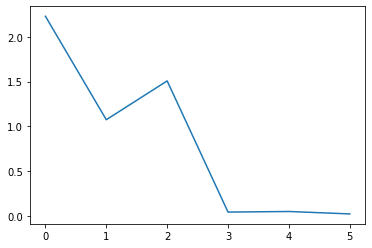

In [ ]:
train_and_eval()

### Посмотрим на результаты с другим количеством слоев

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}
epoch : 0 iter : 0 (0m 0s) 2.2958  / 8 ✗ (24)
epoch : 7 iter : 59 (0m 13s) 2.3189  / 8 ✗ (32)
epoch : 15 iter : 55 (0m 27s) 2.3185  / 8 ✗ (32)
epoch : 23 iter : 51 (0m 41s) 2.2581  / 8 ✗ (48)
epoch : 31 iter : 47 (0m 55s) 2.2564  / 16 ✓
epoch : 39 iter : 43 (1m 9s) 2.2298  / 16 ✗ (23)
epoch : 47 iter : 39 (1m 22s) 2.0768  / 22 ✗ (40)
epoch : 55 iter : 35 (1m 36s) 1.9452  / 22 ✓
epoch : 63 iter : 31 (1m 50s) 1.6476  / 22 ✓
epoch : 71 iter : 27 (2m 4s) 1.8134  / 56 ✓
epoch : 79 iter : 23 (2m 18s) 1.7792  / 8 ✗ (16)
epoch : 87 iter : 19 (2m 31s) 1.6535  / 32 ✗ (56)
epoch : 95 iter : 15 (2m 45s) 1.5799  / 56 ✗ (48)
epoch : 103 iter : 11 (2m 59s) 1.7920  / 8 ✗ (24)
epoch : 111 iter : 7 (3m 13s) 1.4300  / 32 ✗ (23)
epoch : 119 iter : 3 (3m 27s) 1.3943  / 8 ✗ (16)
epoch : 126 iter : 62 (3m 40s) 2.4412  /

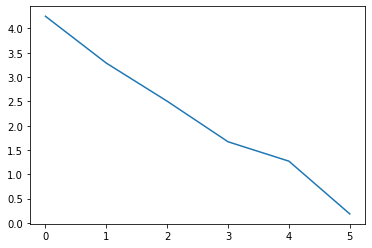

epoch : 0 iter : 0 (0m 0s) 2.2973  / 48 ✗ (10)
epoch : 7 iter : 59 (0m 14s) 2.3024  / 32 ✗ (16)
epoch : 15 iter : 55 (0m 28s) 2.2922  / 32 ✓
epoch : 23 iter : 51 (0m 43s) 2.2896  / 32 ✗ (16)
epoch : 31 iter : 47 (0m 57s) 2.3152  / 32 ✗ (23)
epoch : 39 iter : 43 (1m 12s) 2.2742  / 32 ✗ (16)
epoch : 47 iter : 39 (1m 26s) 2.3333  / 32 ✗ (40)
epoch : 55 iter : 35 (1m 40s) 2.2732  / 32 ✗ (23)
epoch : 63 iter : 31 (1m 55s) 2.2819  / 32 ✗ (23)
epoch : 71 iter : 27 (2m 9s) 2.2393  / 32 ✗ (22)
epoch : 79 iter : 23 (2m 24s) 2.3041  / 32 ✗ (40)
epoch : 87 iter : 19 (2m 38s) 2.2958  / 32 ✗ (48)
epoch : 95 iter : 15 (2m 52s) 2.2648  / 32 ✗ (22)
epoch : 103 iter : 11 (3m 7s) 2.3034  / 32 ✗ (10)
epoch : 111 iter : 7 (3m 21s) 2.3161  / 32 ✗ (40)
epoch : 119 iter : 3 (3m 36s) 2.2898  / 32 ✗ (22)
epoch : 126 iter : 62 (3m 50s) 2.2145  / 32 ✗ (22)
epoch : 134 iter : 58 (4m 4s) 2.2283  / 32 ✗ (48)
epoch : 142 iter : 54 (4m 19s) 2.0939  / 16 ✗ (56)
epoch : 150 iter : 50 (4m 33s) 1.8721  / 32 ✓
epoch : 158 

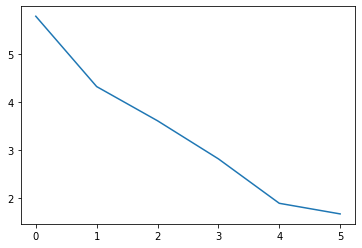

epoch : 0 iter : 0 (0m 0s) 2.3037  / 23 ✗ (8)
epoch : 7 iter : 59 (0m 15s) 2.3024  / 32 ✗ (23)
epoch : 15 iter : 55 (0m 30s) 2.2861  / 32 ✓
epoch : 23 iter : 51 (0m 45s) 2.2841  / 32 ✓
epoch : 31 iter : 47 (1m 0s) 2.2724  / 32 ✗ (16)
epoch : 39 iter : 43 (1m 15s) 2.3117  / 32 ✗ (23)
epoch : 47 iter : 39 (1m 30s) 2.2851  / 32 ✗ (48)
epoch : 55 iter : 35 (1m 46s) 2.2940  / 32 ✗ (8)
epoch : 63 iter : 31 (2m 1s) 2.2773  / 32 ✓
epoch : 71 iter : 27 (2m 16s) 2.2847  / 32 ✗ (56)
epoch : 79 iter : 23 (2m 31s) 2.2903  / 32 ✗ (24)
epoch : 87 iter : 19 (2m 46s) 2.2771  / 32 ✗ (48)
epoch : 95 iter : 15 (3m 1s) 2.2740  / 32 ✗ (56)
epoch : 103 iter : 11 (3m 17s) 2.3206  / 32 ✗ (10)
epoch : 111 iter : 7 (3m 32s) 2.2821  / 32 ✗ (48)
epoch : 119 iter : 3 (3m 47s) 2.3132  / 32 ✗ (22)
epoch : 126 iter : 62 (4m 2s) 2.2922  / 32 ✗ (40)
epoch : 134 iter : 58 (4m 17s) 2.3351  / 32 ✗ (8)
epoch : 142 iter : 54 (4m 33s) 2.3049  / 32 ✗ (8)
epoch : 150 iter : 50 (4m 48s) 2.2819  / 32 ✗ (10)
epoch : 158 iter : 46 

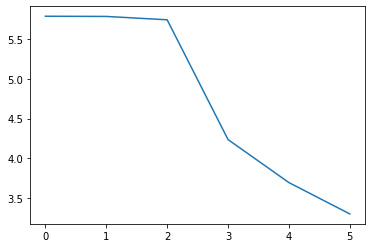

In [ ]:
filter_params['chonk_len']=45
dataset = Skeleton_Dataset(zip_file_path = DATA_ZIP, broken_files_path=broken_files_path, filter_params=filter_params)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
LABELS = dataset.LABELS
n_categories = len(LABELS)
for n_layer in [3, 4, 5]:
  rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
  rnn.to(device)
  train_and_eval()

#### Результаты     
3: 64.37125748502994 (можно доучить, loss не вышел на полочку)     
4: 59.2814371257485 (из графика снижения лосса видно, что еще можно доучить, но судя по худшему результату на тесте, скорее всего уже началось переобучение)     
5: 47.0059880239521


Поучим подольше трехслойную модель

epoch : 0 iter : 0 (0m 0s) 2.3106  / 56 ✗ (32)
epoch : 7 iter : 59 (0m 13s) 2.3093  / 56 ✗ (48)
epoch : 15 iter : 55 (0m 27s) 2.2599  / 8 ✗ (32)
epoch : 23 iter : 51 (0m 41s) 2.2727  / 32 ✗ (40)
epoch : 31 iter : 47 (0m 55s) 2.2557  / 16 ✓
epoch : 39 iter : 43 (1m 8s) 2.1890  / 32 ✓
epoch : 47 iter : 39 (1m 22s) 2.0809  / 22 ✗ (10)
epoch : 55 iter : 35 (1m 36s) 1.7556  / 22 ✗ (32)
epoch : 63 iter : 31 (1m 50s) 1.9664  / 22 ✗ (56)
epoch : 71 iter : 27 (2m 3s) 1.8402  / 16 ✗ (24)
epoch : 79 iter : 23 (2m 17s) 1.5340  / 8 ✗ (16)
epoch : 87 iter : 19 (2m 31s) 1.5105  / 48 ✗ (32)
epoch : 95 iter : 15 (2m 45s) 1.6100  / 24 ✗ (16)
epoch : 103 iter : 11 (2m 59s) 1.5512  / 8 ✓
epoch : 111 iter : 7 (3m 12s) 1.4573  / 56 ✓
epoch : 119 iter : 3 (3m 26s) 1.6107  / 56 ✗ (48)
epoch : 126 iter : 62 (3m 40s) 1.5310  / 32 ✗ (23)
epoch : 134 iter : 58 (3m 53s) 1.6829  / 56 ✗ (24)
epoch : 142 iter : 54 (4m 7s) 1.5136  / 8 ✓
epoch : 150 iter : 50 (4m 21s) 1.3338  / 8 ✓
epoch : 158 iter : 46 (4m 34s) 1.1995

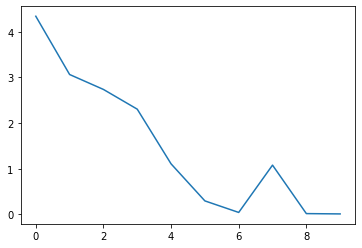

In [ ]:
n_layer = 3
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)
train_and_eval()

#### Результат 63.17365269461078. Было лучше

### Меняем количество "кадров"

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}
epoch : 0 iter : 0 (0m 0s) 2.3002  / 24 ✗ (32)
epoch : 7 iter : 24 (0m 11s) 2.2839  / 16 ✓
epoch : 14 iter : 48 (0m 23s) 2.2476  / 22 ✗ (48)
epoch : 22 iter : 4 (0m 35s) 1.9929  / 16 ✓
epoch : 29 iter : 28 (0m 47s) 1.8688  / 16 ✗ (56)
epoch : 36 iter : 52 (0m 59s) 1.6817  / 16 ✓
epoch : 44 iter : 8 (1m 11s) 1.7559  / 22 ✗ (48)
epoch : 51 iter : 32 (1m 23s) 1.7235  / 22 ✓
epoch : 58 iter : 56 (1m 35s) 1.6135  / 10 ✗ (22)
epoch : 66 iter : 12 (1m 47s) 1.3575  / 16 ✓
epoch : 73 iter : 36 (1m 59s) 1.3881  / 8 ✗ (24)
epoch : 80 iter : 60 (2m 11s) 1.2357  / 22 ✓
epoch : 88 iter : 16 (2m 22s) 1.2152  / 23 ✗ (48)
epoch : 95 iter : 40 (2m 34s) 1.3510  / 56 ✓
epoch : 102 iter : 64 (2m 46s) 1.3684  / 8 ✗ (16)
epoch : 110 iter : 20 (2m 58s) 1.6020  / 56 ✓
epoch : 117 iter : 44 (3m 10s) 1.1065  / 22 ✓
epoch : 

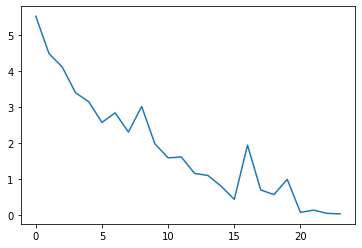

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}
epoch : 0 iter : 0 (0m 0s) 2.3070  / 8 ✗ (16)
epoch : 7 iter : 10 (0m 10s) 2.2907  / 48 ✗ (23)
epoch : 14 iter : 20 (0m 21s) 2.2055  / 16 ✗ (24)
epoch : 21 iter : 30 (0m 32s) 1.9395  / 10 ✗ (23)
epoch : 28 iter : 40 (0m 42s) 1.7096  / 16 ✓
epoch : 35 iter : 50 (0m 53s) 1.6799  / 56 ✗ (48)
epoch : 42 iter : 60 (1m 4s) 1.9515  / 56 ✓
epoch : 50 iter : 0 (1m 15s) 1.4090  / 24 ✗ (56)
epoch : 57 iter : 10 (1m 26s) 1.4871  / 23 ✓
epoch : 64 iter : 20 (1m 36s) 1.5443  / 10 ✗ (23)
epoch : 71 iter : 30 (1m 47s) 1.3804  / 8 ✗ (16)
epoch : 78 iter : 40 (1m 58s) 1.0956  / 23 ✗ (32)
epoch : 85 iter : 50 (2m 9s) 1.7647  / 23 ✓
epoch : 92 iter : 60 (2m 20s) 0.9099  / 16 ✓
epoch : 100 iter : 0 (2m 30s) 0.9877  / 40 ✗ (32)
epoch : 107 iter : 10 (2m 41s) 1.2886  / 24 ✓
epoch : 114 iter : 20 (2m 52s) 0.8761  / 48 ✗ 

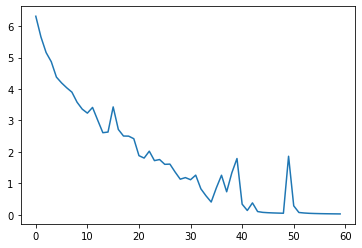

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}
epoch : 0 iter : 0 (0m 0s) 2.2980  / 23 ✗ (40)
epoch : 6 iter : 68 (0m 8s) 2.3068  / 56 ✗ (24)
epoch : 13 iter : 64 (0m 16s) 2.2849  / 56 ✗ (8)
epoch : 20 iter : 60 (0m 25s) 2.1453  / 22 ✗ (32)
epoch : 27 iter : 56 (0m 33s) 2.1796  / 24 ✗ (10)
epoch : 34 iter : 52 (0m 42s) 1.9542  / 48 ✓
epoch : 41 iter : 48 (0m 50s) 1.8397  / 22 ✗ (32)
epoch : 48 iter : 44 (0m 59s) 1.8406  / 22 ✓
epoch : 55 iter : 40 (1m 7s) 1.6909  / 22 ✓
epoch : 62 iter : 36 (1m 16s) 1.8600  / 32 ✗ (16)
epoch : 69 iter : 32 (1m 24s) 1.5101  / 23 ✗ (22)
epoch : 76 iter : 28 (1m 33s) 1.6575  / 23 ✗ (22)
epoch : 83 iter : 24 (1m 41s) 1.9060  / 23 ✗ (40)
epoch : 90 iter : 20 (1m 50s) 1.5696  / 56 ✓
epoch : 97 iter : 16 (1m 58s) 1.5412  / 56 ✓
epoch : 104 iter : 12 (2m 7s) 1.2481  / 40 ✗ (23)
epoch : 111 iter : 8 (2m 15s) 1.0900  / 

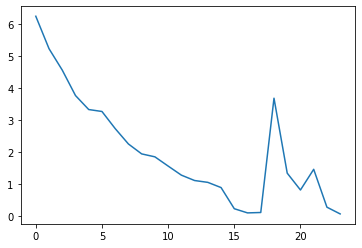

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}
epoch : 0 iter : 0 (0m 0s) 2.3097  / 32 ✗ (23)
epoch : 6 iter : 68 (0m 7s) 2.2573  / 10 ✗ (24)
epoch : 13 iter : 64 (0m 14s) 2.2024  / 16 ✗ (56)
epoch : 20 iter : 60 (0m 21s) 2.1834  / 8 ✗ (48)
epoch : 27 iter : 56 (0m 29s) 2.0841  / 40 ✗ (10)
epoch : 34 iter : 52 (0m 36s) 2.1311  / 48 ✗ (8)
epoch : 41 iter : 48 (0m 43s) 2.0019  / 40 ✗ (32)
epoch : 48 iter : 44 (0m 50s) 1.8387  / 32 ✗ (48)
epoch : 55 iter : 40 (0m 58s) 2.3146  / 8 ✗ (23)
epoch : 62 iter : 36 (1m 5s) 1.3798  / 22 ✓
epoch : 69 iter : 32 (1m 12s) 1.8553  / 16 ✓
epoch : 76 iter : 28 (1m 20s) 1.4727  / 8 ✓
epoch : 83 iter : 24 (1m 27s) 1.7122  / 16 ✓
epoch : 90 iter : 20 (1m 34s) 1.8050  / 32 ✗ (10)
epoch : 97 iter : 16 (1m 41s) 1.1947  / 24 ✗ (10)
epoch : 104 iter : 12 (1m 49s) 1.5425  / 48 ✓
epoch : 111 iter : 8 (1m 56s) 1.4865  / 56

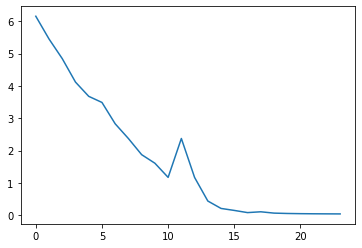

In [ ]:
for chonk_len in [40, 35, 25, 20]:
  filter_params['chonk_len'] = chonk_len
  dataset = Skeleton_Dataset(zip_file_path = DATA_ZIP, broken_files_path=broken_files_path, filter_params=filter_params)
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), len(dataset) - int(0.75*len(dataset))])
  train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

  n_hidden = 128
  n_joints = 25*3
  LABELS = dataset.LABELS
  n_categories = len(LABELS)
  n_layer = 2
  rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
  rnn.to(device)

  train_and_eval()

#### Результаты:

40: 65.45961002785515     
35: 66.66666666666667     
25: 64.56692913385827     
20: 64.30446194225722

### Посчитаем еще для 30

action classes:  {32: 0, 56: 1, 8: 2, 22: 3, 16: 4, 24: 5, 48: 6, 40: 7, 10: 8, 23: 9}
action files:  {32: 120, 56: 120, 8: 120, 22: 120, 16: 120, 24: 120, 48: 120, 40: 120, 10: 120, 23: 120}
epoch : 0 iter : 0 (0m 0s) 2.2519  / 22 ✗ (32)
epoch : 6 iter : 68 (0m 9s) 2.2862  / 16 ✗ (22)
epoch : 13 iter : 64 (0m 19s) 2.2513  / 22 ✗ (10)
epoch : 20 iter : 60 (0m 28s) 2.1667  / 22 ✓
epoch : 27 iter : 56 (0m 38s) 1.9723  / 24 ✗ (56)
epoch : 34 iter : 52 (0m 47s) 1.8245  / 24 ✓
epoch : 41 iter : 48 (0m 57s) 1.6744  / 16 ✗ (23)
epoch : 48 iter : 44 (1m 7s) 2.0327  / 56 ✗ (40)
epoch : 55 iter : 40 (1m 16s) 1.5438  / 22 ✓
epoch : 62 iter : 36 (1m 26s) 1.6098  / 16 ✓
epoch : 69 iter : 32 (1m 35s) 1.4082  / 56 ✗ (48)
epoch : 76 iter : 28 (1m 45s) 1.4806  / 40 ✓
epoch : 83 iter : 24 (1m 55s) 1.8350  / 23 ✗ (22)
epoch : 90 iter : 20 (2m 4s) 1.0732  / 8 ✓
epoch : 97 iter : 16 (2m 14s) 1.6581  / 56 ✓
epoch : 104 iter : 12 (2m 23s) 1.6505  / 56 ✗ (32)
epoch : 111 iter : 8 (2m 33s) 0.9749  / 48 ✓
epoch

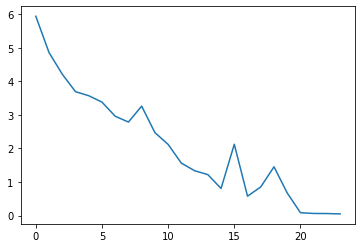

In [ ]:
filter_params['chonk_len'] = 30
dataset = Skeleton_Dataset(zip_file_path = DATA_ZIP, broken_files_path=broken_files_path, filter_params=filter_params)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

n_hidden = 128
n_joints = 25*3
LABELS = dataset.LABELS
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

train_and_eval()

#### Лучший результат достигнут на 35 кадрах